## Pre-Trained Models



In [ ]:
from skimage.metrics import structural_similarity
import imageio as io
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

In [ ]:
IMG_FOLDER = '/content/drive/MyDrive/WMCA/GoogleStreetView/'
im_list = []

for f in os.listdir(IMG_FOLDER):
  im_list.append(io.imread(IMG_FOLDER + f))

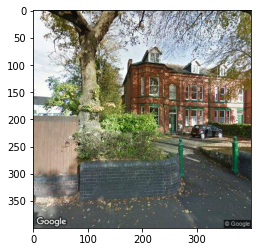

In [ ]:
plt.imshow(im_list[0])

## Structural Similarity
ORB is a feature detection algorithm built on FAST keypoint detector and the BRIEF descriptor.
- FAST (Features from Accelerated and Segments Test): edge detection by computing the relative brightness of a pixel to its neighours (circle). Selected pixels above a threshold are called keypoints. Creates a multiscale image pyramid where each higher level is a lower resolution of the image. Works better on less crisp images.
- BRIEF (Binary robust independent elementary feature): Combines patches (neighbourhood around a keypoint) into a vector representation of a feature.

In [ ]:
def orb_sim(img1, img2):
  # SIFT is no longer available in cv2 so using ORB
  orb = cv2.ORB_create()

  # detect keypoints and descriptors
  kp_a, desc_a = orb.detectAndCompute(img1, None)
  kp_b, desc_b = orb.detectAndCompute(img2, None)

  # define the bruteforce matcher object
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
  #perform matches. 
  matches = bf.match(desc_a, desc_b)

  #Look for similar regions with distance < 50. Goes from 0 to 100 so pick a number between.
  similar_regions = [i for i in matches if i.distance < 50]  
  if len(matches) == 0:
    return 0
    
  return len(similar_regions) / len(matches)

In [ ]:
#Needs images to be same dimensions
def structural_sim(img1, img2):
  sim, diff = structural_similarity(img1, img2, full=True)
  return sim

In [ ]:
orb_similarity = np.zeros((len(im_list), len(im_list)))

for i in range(len(im_list)):
  for j in range(len(im_list)-1-i):
    orb_similarity[i][j+i] = orb_sim(im_list[i], im_list[j+i]) 

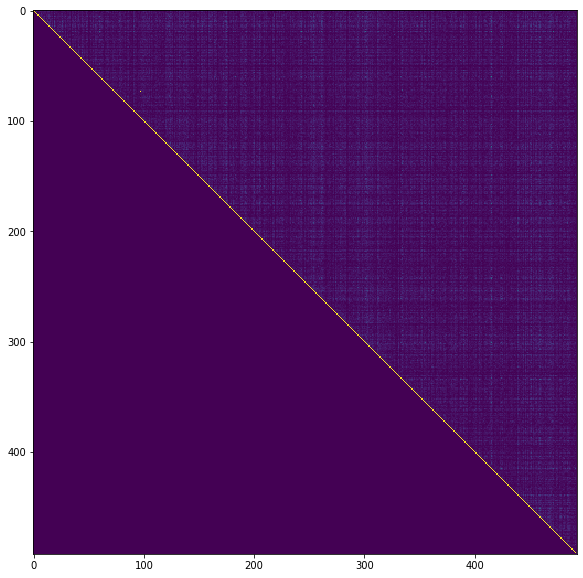

In [ ]:
#1.0 means identical. Lower = not similar
plt.figure(figsize=(10,10))
plt.imshow(orb_similarity, cmap='viridis', interpolation='nearest')
plt.show()

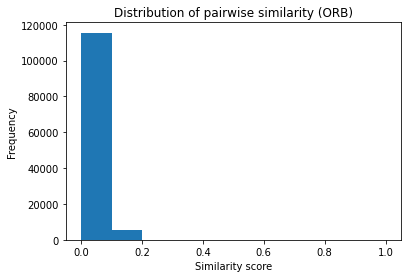

In [ ]:
orb_similarity = np.triu(orb_similarity, 1)
plt.hist(orb_similarity[np.triu_indices(len(im_list), k=1)])
plt.xlabel('Similarity score')
plt.ylabel('Frequency')
plt.title('Distribution of pairwise similarity (ORB)')
plt.show()

## Cosine Distance

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from scipy.spatial import distance
import numpy as np

In [ ]:
model_url = "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2"

IMAGE_SHAPE = (224, 224)

layer = hub.KerasLayer(model_url)
model = tf.keras.Sequential([layer])

In [ ]:
def extract(file):
  file = Image.open(file).convert('L').resize(IMAGE_SHAPE)
  #display(file)

  file = np.stack((file,)*3, axis=-1)

  file = np.array(file)/255.0

  embedding = model.predict(file[np.newaxis, ...])
  # print(embedding)
  vgg16_feature_np = np.array(embedding)
  flattended_feature = vgg16_feature_np.flatten()

  # print(len(flattended_feature))
  # print(flattended_feature)
  # print('-----------')
  return flattended_feature

In [ ]:
IMG_FOLDER = '/content/drive/MyDrive/WMCA/GoogleStreetView/'
im_file_list = [IMG_FOLDER+f for f in os.listdir(IMG_FOLDER)]
im_extracted = [extract(im) for im in im_file_list]

In [ ]:
metric = 'cosine'
cosine_distance = np.zeros((len(im_file_list), len(im_file_list)))

for i in range(len(im_file_list)):
  for j in range(len(im_file_list)-1-i):
    cosine_distance[i][j+i] = distance.cdist(
        [im_extracted[i]], [im_extracted[j+i]], metric)[0][0]

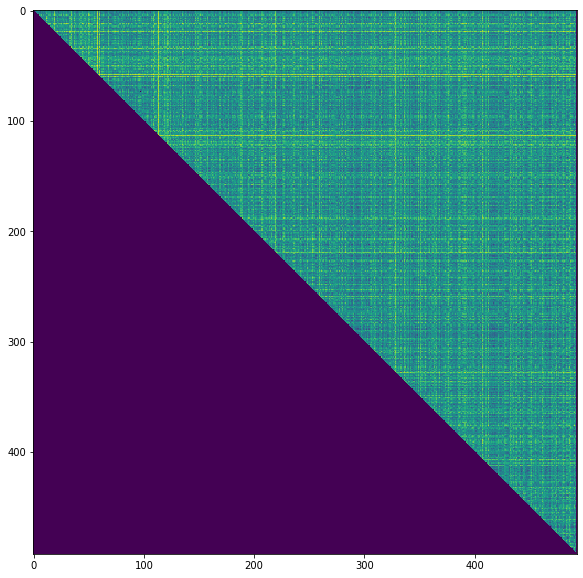

In [ ]:
#1.0 means identical. Lower = not similar
plt.figure(figsize=(10,10))
plt.imshow(cosine_distance, cmap='viridis', interpolation='nearest')
plt.show()

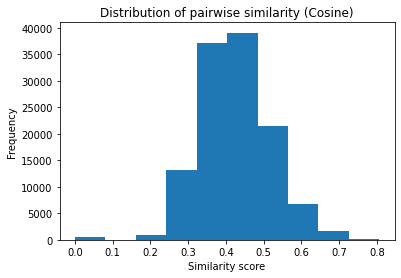

In [ ]:
zorb_similarity = np.triu(cosine_distance, 1)
plt.hist(cosine_distance[np.triu_indices(len(im_list), k=1)])
plt.xlabel('Similarity score')
plt.ylabel('Frequency')
plt.title('Distribution of pairwise similarity (Cosine)')
plt.show()